In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bounce = pd.read_csv('./ReducedData/BC_AllPlayers.csv')[['gameId','playId','x_fb','y_fb','x_punt','y_punt','x_land','y_land','hangTime','Type','specialTeamsResult']]
bounce = bounce[bounce['Type']=='Bounce']

landing = pd.read_csv('./ReducedData/BounceCatch.csv').merge(bounce[['gameId','playId']])
landing.rename({'frameId':'landFrame'},axis=1,inplace=True)

play_data = pd.read_csv('./data/plays.csv')
bounce_play = play_data[['gameId','playId','kickLength','penaltyYards','specialTeamsResult']].merge(bounce[['gameId','playId']])

pff_data = pd.read_csv('./data/PFFScoutingData.csv')
bounce_pff = pff_data[['gameId','playId','kickType','kickContactType']].merge(bounce[['gameId','playId']])

data = bounce.drop(columns=['Type']).merge(bounce_play).merge(bounce_pff)
data['diff'] = data['kickLength'] - (data['x_land']-data['x_fb'])

In [2]:
# 2018 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2018.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_18 = football_tracking.merge(landing[['gameId','playId','landFrame']])
punt_fbtrack_18['time'] = pd.to_datetime(punt_fbtrack_18['time'])

# 2019 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2019.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_19 = football_tracking.merge(landing[['gameId','playId','landFrame']])
punt_fbtrack_19['time'] = pd.to_datetime(punt_fbtrack_19['time'])

# 2020 Football Tracking Data
tracking_game = pd.read_csv('./data/tracking2020.csv', chunksize=10**5)
football_tracking = pd.concat((x.query("displayName == 'football'") for x in tracking_game), ignore_index=True)
punt_fbtrack_20 = football_tracking.merge(landing[['gameId','playId','landFrame']])
punt_fbtrack_20['time'] = pd.to_datetime(punt_fbtrack_20['time'])

punt_fbtrack = pd.concat([punt_fbtrack_18,punt_fbtrack_19,punt_fbtrack_20]) \
                .sort_values(by=['gameId','playId','frameId']) \
                .drop(columns=['o','dir','nflId','displayName','jerseyNumber','position','team']) \
                .reset_index(drop=True)

after_land = punt_fbtrack[punt_fbtrack['frameId']>=punt_fbtrack['landFrame']]

In [3]:
ground_event_list = ['punt_downed','out_of_bounds','touchback','punt_received','punt_muffed','fair_catch','kick_received']
final_event = after_land[after_land['event'].isin(ground_event_list)].drop_duplicates(subset=['gameId','playId'])
remain = after_land.merge(final_event[['gameId','playId']],indicator=True,how='outer').query('_merge == "left_only"').drop(columns=['_merge'])

result_to_event = {'Downed':'punt_downed','Fair Catch':'fair_catch','Muffed':'punt_muffed','Out of Bounds':'out_of_bounds','Touchback':'touchback','Return':'Return'}
fe_merged = final_event.merge(bounce_play)#[['specialTeamsResult','event']].value_counts(dropna=False).sort_index(level=0)
fe_merged['event_check'] = fe_merged['specialTeamsResult'].map(result_to_event)

In [4]:
# (5) Result = Muffed > Event = out_of_bounds ------ See below
# gameId = 2018092000,playId = 801 : event = fumble_defense_recovered
# gameId = 2018093005,playId = 3731 : frame = 88 roughly
# gameId = 2018102104,playId = 789 : Questionable, little impact of what to choose tbh
# gameId = 2018122309,playId = 3195 : Hard to see what frame the muff happens
# gameId = 2020101112,playId = 1389 : Same
# Two options to deal with these:
# 1) Drop these events entirely.  Generally the ball does not bounce for long before being muffed
# 2) Keep as is.  The muffed punt does not change the trajectory of the ball much
# Go with (1)

# (1) Result = Downed > Event = fair_catch --------- 'Fake' fair catch -> skip to downed event
# (5) Result = Downed > Event = punt_received ------ 2019: 'Fake' received (3) -> skip to downed event. 2020: Correct values (2)

# All of the rest of the mismatched events are correct.

correct = fe_merged.query('(event_check == event)|(event_check == "Return")')
check_events = fe_merged.query('(event_check != event)&(event_check != "Return")')

dropped_events = check_events.query('(specialTeamsResult == "Muffed")&(event == "out_of_bounds")')
reeval_events = check_events.query('(specialTeamsResult == "Downed")&((event == "fair_catch")|((event == "punt_received")&(gameId//10**6 == 2019)))')
reeval_events

checked = check_events.merge(dropped_events,how='outer',indicator=True).query('_merge == "left_only"').drop(columns=['_merge']) \
    .merge(reeval_events,how='outer',indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
correct = pd.concat([correct,checked,after_land.merge(reeval_events[['gameId','playId']]).query('event == "punt_downed"')])

In [5]:
after_land

,time,x,y,s,a,dis,event,frameId,gameId,playId,playDirection,landFrame
75,2018-09-07 01:40:33.200,96.45,39.01,7.59,3.18,0.87,None,76,2018090600,872,right,76
76,2018-09-07 01:40:33.300,97.17,39.47,7.66,2.74,0.86,punt_land,77,2018090600,872,right,76
77,2018-09-07 01:40:33.400,97.86,39.98,7.79,2.49,0.86,None,78,2018090600,872,right,76
78,2018-09-07 01:40:33.500,98.52,40.51,7.76,2.51,0.85,None,79,2018090600,872,right,76
79,2018-09-07 01:40:33.600,99.17,41.08,7.91,2.46,0.87,None,80,2018090600,872,right,76
...,...,...,...,...,...,...,...,...,...,...,...,...
178955,2021-01-04 00:15:41.400,23.70,1.01,2.28,1.55,0.23,None,116,2021010314,3831,left,75
178956,2021-01-04 00:15:41.500,23.53,0.85,2.28,0.98,0.23,None,117,2021010314,3831,left,75
178957,2021-01-04 00:15:41.600,23.37,0.69,2.25,0.78,0.22,None,118,2021010314,3831,left,75
178958,2021-01-04 00:15:41.700,23.22,0.52,2.28,0.54,0.23,None,119,2021010314,3831,left,75


In [6]:
end_bounce = correct[['gameId','playId','x','y','frameId']].copy()
fb_bounce_data = end_bounce.merge(landing,on=['gameId','playId'],suffixes=('_final','_land')).drop(columns=['Type'])
fb_bounce_data = fb_bounce_data[['gameId','playId','x_land','y_land','x_final','y_final','landFrame','frameId','hangTime','playDirection']]
fb_bounce_data['x_land'] += (120 - 2*fb_bounce_data['x_land'])*(fb_bounce_data['playDirection']=='left')
fb_bounce_data['y_land'] += ((160/3 - 2*fb_bounce_data['y_land'])*(fb_bounce_data['playDirection']=='left')).round(2)
fb_bounce_data['x_final'] += (120 - 2*fb_bounce_data['x_final'])*(fb_bounce_data['playDirection']=='left')
fb_bounce_data['y_final'] += ((160/3 - 2*fb_bounce_data['y_final'])*(fb_bounce_data['playDirection']=='left')).round(2)
fb_bounce_data.sort_values(['gameId','playId'])

,gameId,playId,x_land,y_land,x_final,y_final,landFrame,frameId,hangTime,playDirection
0,2018090600,872,96.45,39.01,110.34,49.56,76,99,4.35,right
1,2018090600,1850,99.51,9.79,100.66,10.83,78,93,4.53,left
2,2018090600,3026,85.08,41.61,93.72,38.28,81,126,4.66,right
3,2018090600,3736,71.87,46.20,77.40,56.68,75,91,4.20,right
4,2018090900,575,91.59,49.20,98.16,52.11,75,91,4.20,right
...,...,...,...,...,...,...,...,...,...,...
1511,2021010314,209,102.98,17.51,105.71,20.67,79,98,4.63,left
1512,2021010314,527,80.50,10.29,89.96,18.81,66,118,3.24,left
1513,2021010314,2689,106.46,27.13,117.83,28.25,76,96,4.25,left
1514,2021010314,3395,78.21,1.13,80.55,-3.70,81,89,4.62,left


In [7]:
def calc_const(dist, ht):
    g = 32.1/3
    v_const = (dist/ht)**2 + (g*ht/2)**2
    return np.sqrt(v_const)

fb_locations = data[['gameId','playId','x_fb','y_fb','x_punt','y_punt']].merge(fb_bounce_data,on=['gameId','playId'])

fb_locations['dx_air'] = fb_locations['x_land']-fb_locations['x_punt']
fb_locations['dy_air'] = fb_locations['y_land']-fb_locations['y_punt']
fb_locations['dist_air'] = np.sqrt(fb_locations['dx_air']**2 + fb_locations['dy_air']**2).round(2)
fb_locations['v_c'] = calc_const(fb_locations['dist_air'],fb_locations['hangTime'])
fb_locations['v_field_ratio'] = fb_locations['dist_air']/fb_locations['hangTime'] / fb_locations['v_c']

fb_locations['dx_bounce'] = fb_locations['x_final']-fb_locations['x_land']
fb_locations['dy_bounce'] = fb_locations['y_final']-fb_locations['y_land']
fb_locations['dist_bounce'] = np.sqrt(fb_locations['dx_bounce']**2 + fb_locations['dy_bounce']**2).round(2)

fb_locations['cos_air_bounce'] = (fb_locations['dx_air']*fb_locations['dx_bounce'] + fb_locations['dy_air']*fb_locations['dy_bounce'])/(fb_locations['dist_air'])#*fb_locations['dist_bounce'])
fb_locations['sin_air_bounce'] = (-fb_locations['dy_air']*fb_locations['dx_bounce'] + fb_locations['dx_air']*fb_locations['dy_bounce'])/(fb_locations['dist_air'])#*fb_locations['dist_bounce'])

fb_locations = fb_locations.fillna(0).drop(columns=['x_land','y_land','x_final','y_final','landFrame','frameId','playDirection'])
fb_locations

,gameId,playId,x_fb,y_fb,x_punt,y_punt,hangTime,dx_air,dy_air,dist_air,v_c,v_field_ratio,dx_bounce,dy_bounce,dist_bounce,cos_air_bounce,sin_air_bounce
0,2018090600,872,45,29.95,31.24,31.11,4.35,65.21,7.90,65.69,27.742638,0.544330,13.89,10.55,17.44,15.057267,8.802474
1,2018090600,1850,41,23.36,27.30,24.63,4.53,72.21,-14.84,73.72,29.192358,0.557465,1.15,1.04,1.55,0.917090,1.250195
2,2018090600,3026,50,23.94,36.10,23.22,4.66,48.98,18.39,52.32,27.342472,0.410624,8.64,-3.33,9.26,6.917976,-6.154300
3,2018090600,3736,31,25.59,17.47,26.64,4.20,54.40,19.56,57.81,26.350644,0.522351,5.53,10.48,11.85,8.749711,7.990749
4,2018090900,575,36,23.63,22.18,24.70,4.20,69.41,24.50,73.61,28.496811,0.615023,6.57,2.91,7.19,7.163683,0.557235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2021010314,209,51,23.56,36.77,24.47,4.63,66.21,-6.96,66.57,28.640944,0.502008,2.73,3.16,4.18,2.384854,3.428337
1563,2021010314,527,45,23.71,30.77,24.57,3.24,49.73,-14.28,51.74,23.568641,0.677559,9.46,8.52,12.73,6.741017,10.799930
1564,2021010314,2689,62,23.90,47.81,24.59,4.25,58.65,2.54,58.70,26.603736,0.519166,11.37,1.12,11.43,11.408779,0.627056
1565,2021010314,3395,32,23.87,18.08,25.05,4.62,60.13,-23.92,64.71,28.409716,0.493018,2.34,-4.83,5.37,3.959787,-3.623166


In [8]:
fb_locations.corr()[['dx_bounce','dy_bounce','dist_bounce','cos_air_bounce','sin_air_bounce']].iloc[2:-5]

,dx_bounce,dy_bounce,dist_bounce,cos_air_bounce,sin_air_bounce
x_fb,-0.199405,-0.054077,-0.269853,-0.212748,-0.049422
y_fb,-0.020470,-0.023946,-0.012979,-0.021328,-0.015194
x_punt,-0.199935,-0.054754,-0.272266,-0.213454,-0.050215
y_punt,-0.014075,-0.014851,-0.010217,-0.015287,0.011221
hangTime,-0.181810,-0.084893,-0.179747,-0.202772,-0.092407
dx_air,0.031375,-0.015874,0.015386,0.012658,-0.013591
dy_air,-0.066583,0.296842,-0.077561,-0.059926,0.067404
dist_air,0.004362,-0.015484,-0.024213,-0.006007,-0.017894
v_c,-0.093326,-0.053604,-0.103499,-0.111452,-0.064837
v_field_ratio,0.218840,0.090378,0.202895,0.236417,0.096064


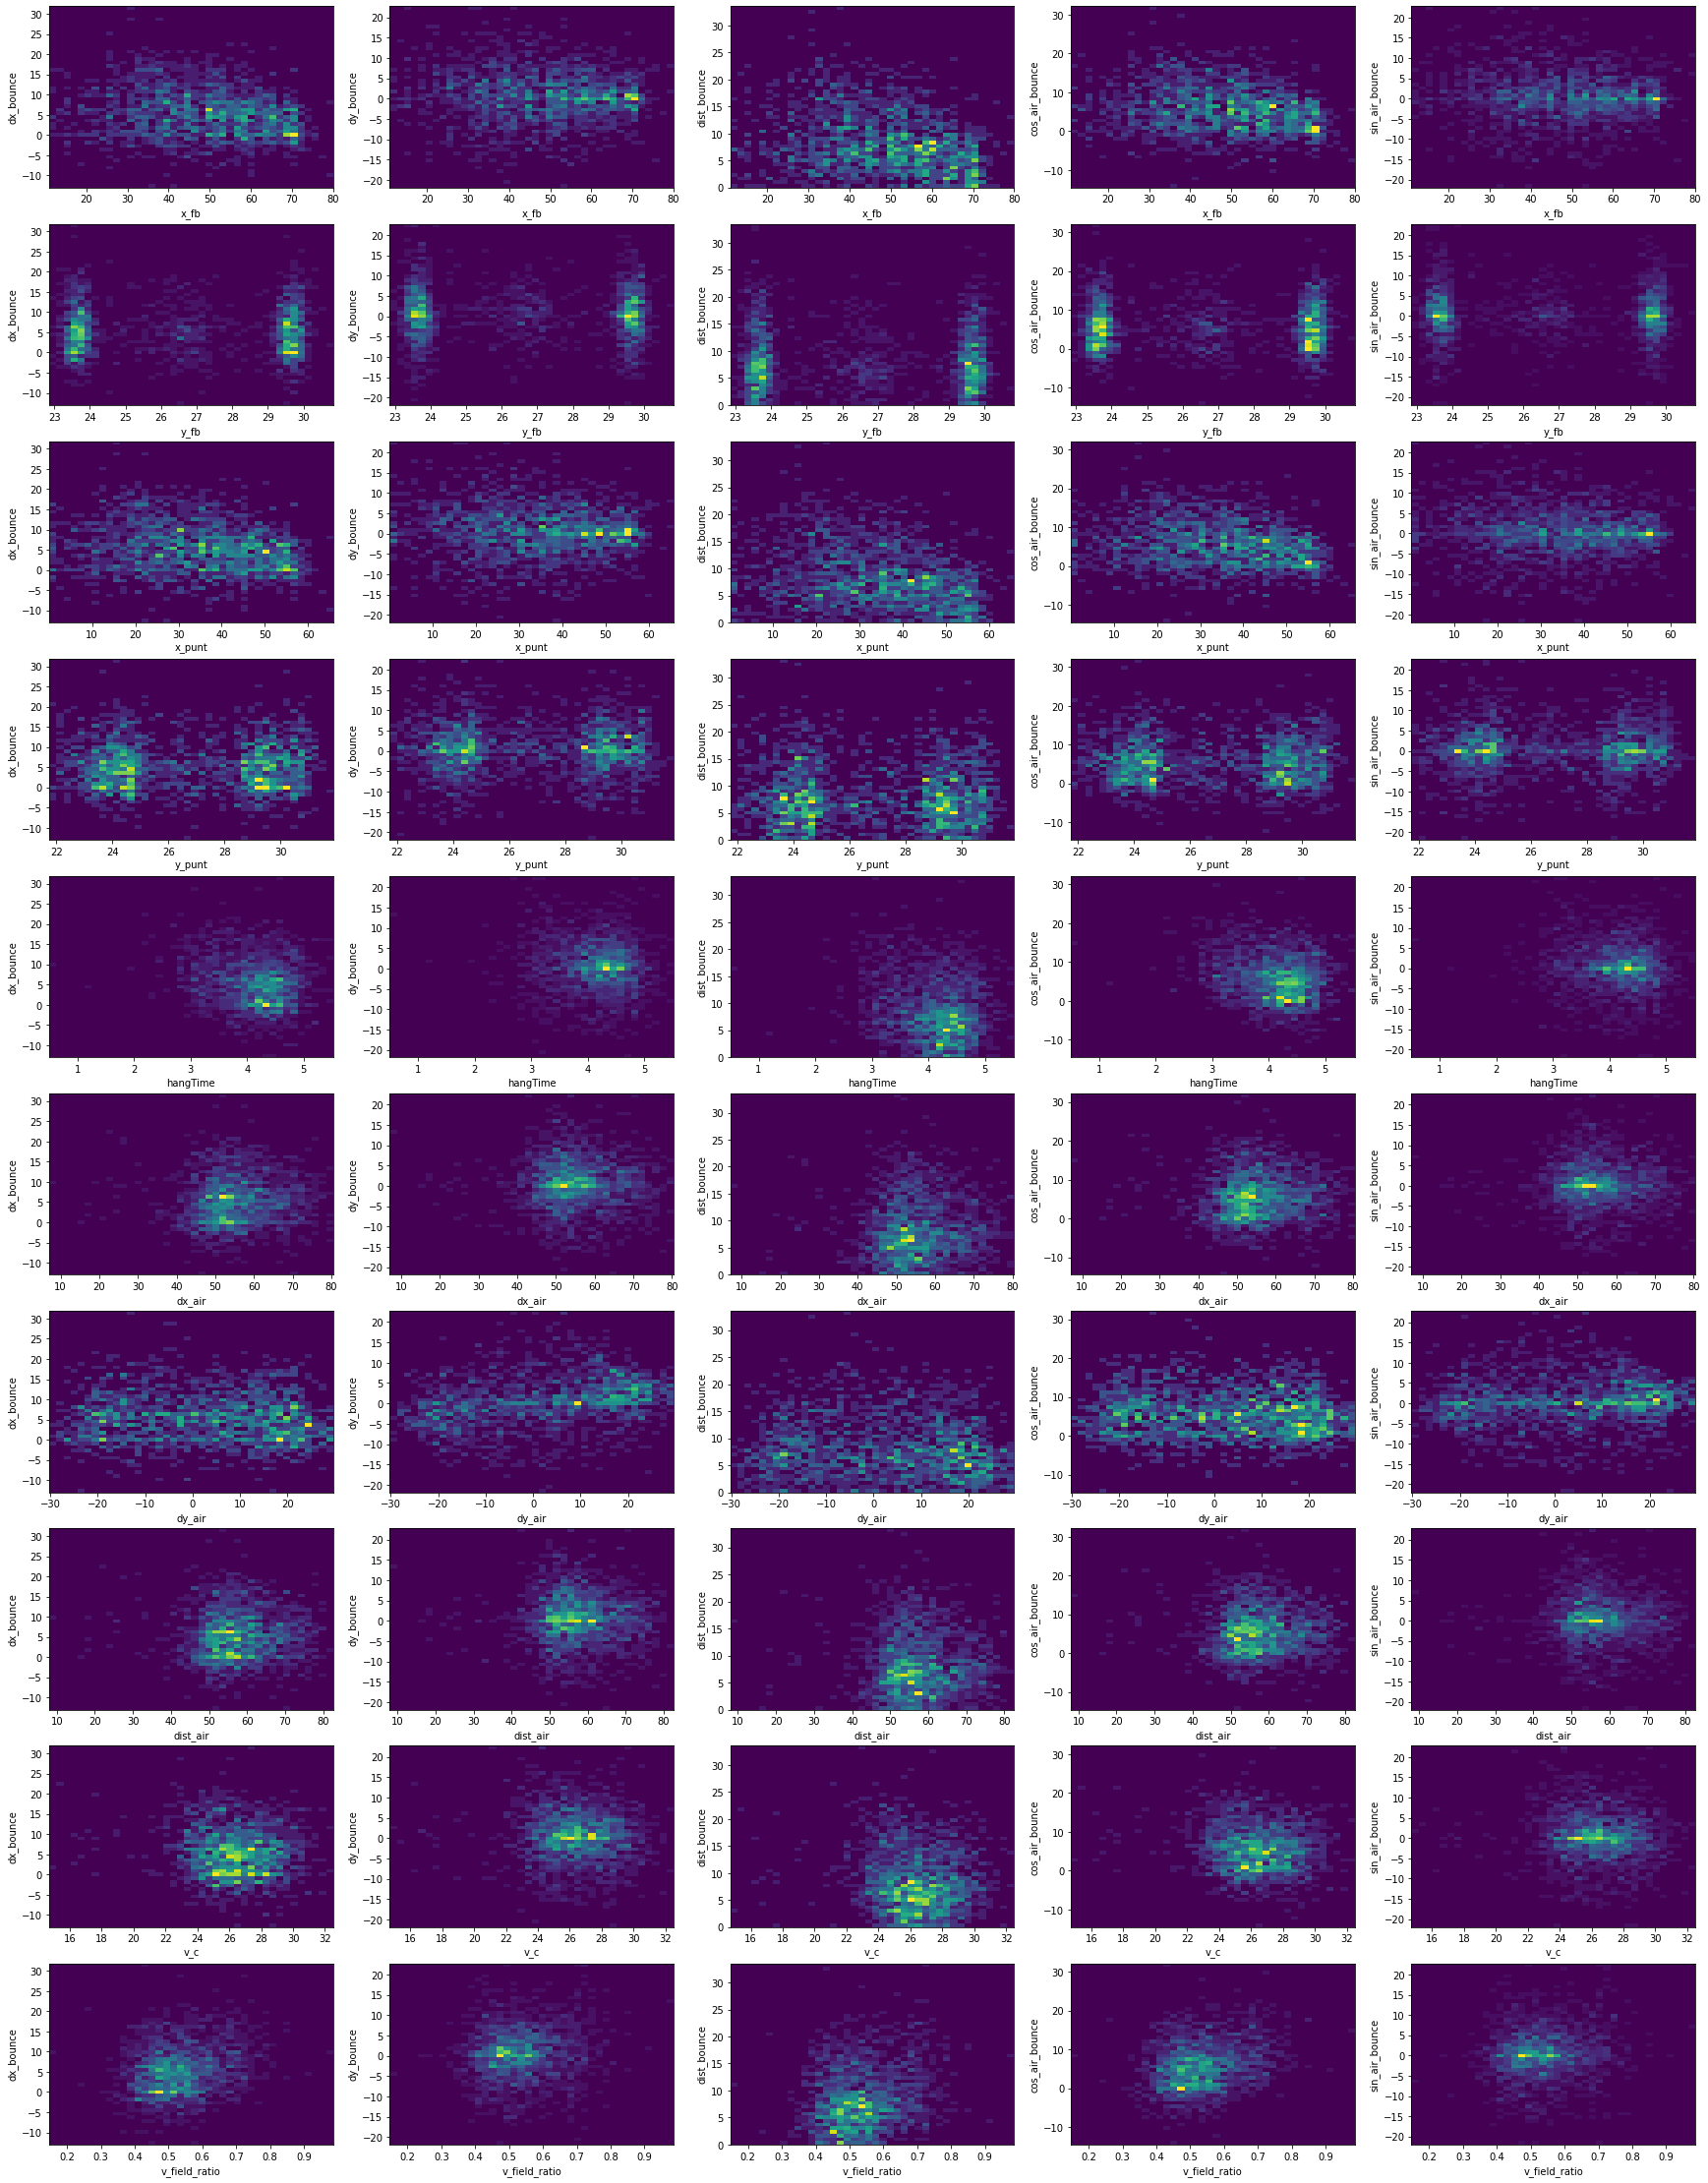

In [9]:
x_labels = fb_locations.columns[2:12]#np.r_[2,6,8:12]]
y_labels = fb_locations.columns[-5:]

fig,ax = plt.subplots(10,5,figsize=(30,40))
for i,col in enumerate(x_labels):
    for j,out in enumerate(y_labels):
        ax[i,j].hist2d(fb_locations[col],fb_locations[out],bins=[40,50])
        ax[i,j].set(xlabel=col,ylabel=out)

In [15]:
fb_locations.to_csv('./ReducedData/BounceFeatures.csv',index=True)